# Task 3: Customer Segmentation / Clustering#%% md


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions - Transactions.csv")

In [27]:
# Inspect datasets
def inspect_data(df, name):
    print(f"\n{name} Dataset Overview")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("Sample Data:")
    print(df.head(), "\n")
    print("Missing Values:")
    print(df.isnull().sum(), "\n")

inspect_data(customers, "Customers")
inspect_data(transactions, "Transactions")



Customers Dataset Overview
--------------------------------------------------
Shape: (200, 4)
Columns: ['CustomerID', 'CustomerName', 'Region', 'SignupDate']
Sample Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15 

Missing Values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64 


Transactions Dataset Overview
--------------------------------------------------
Shape: (1000, 7)
Columns: ['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price']
Sample Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1

# Data preparation

In [28]:
# Merge datasets on CustomerID
customer_transactions = transactions.merge(customers, on="CustomerID")

## Feature Engineering

In [29]:
# Calculate total spending per customer
total_spending = customer_transactions.groupby("CustomerID")["TotalValue"].sum().reset_index()
total_spending.rename(columns={"TotalValue": "TotalSpending"}, inplace=True)

In [30]:
# Calculate transaction frequency per customer
transaction_frequency = customer_transactions.groupby("CustomerID")["TransactionID"].count().reset_index()
transaction_frequency.rename(columns={"TransactionID": "TransactionFrequency"}, inplace=True)

In [31]:
# Merge the features into a single dataframe
customer_features = customers.merge(total_spending, on="CustomerID", how="left")
customer_features = customer_features.merge(transaction_frequency, on="CustomerID", how="left")


In [32]:
# Fill missing values
customer_features["TotalSpending"] = customer_features["TotalSpending"].fillna(0)
customer_features["TransactionFrequency"] = customer_features["TransactionFrequency"].fillna(0)

In [33]:
# Select features for clustering
clustering_data = customer_features[["TotalSpending", "TransactionFrequency"]]

In [34]:
# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

## Clustering

In [35]:
# Test different numbers of clusters and calculate DB Index
cluster_range = range(2, 11)
db_indices = []
silhouette_scores = []

In [36]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    silhouette = silhouette_score(scaled_data, labels)
    db_indices.append(db_index)
    silhouette_scores.append(silhouette)

# Choose the best number of clusters based on DB Index
optimal_k = cluster_range[np.argmin(db_indices)]

In [37]:
# Final K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(scaled_data)
silhouette_optimal = silhouette_score(scaled_data, customer_features["Cluster"])


In [38]:
# Visualization using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
customer_features["PCA1"] = pca_result[:, 0]
customer_features["PCA2"] = pca_result[:, 1]

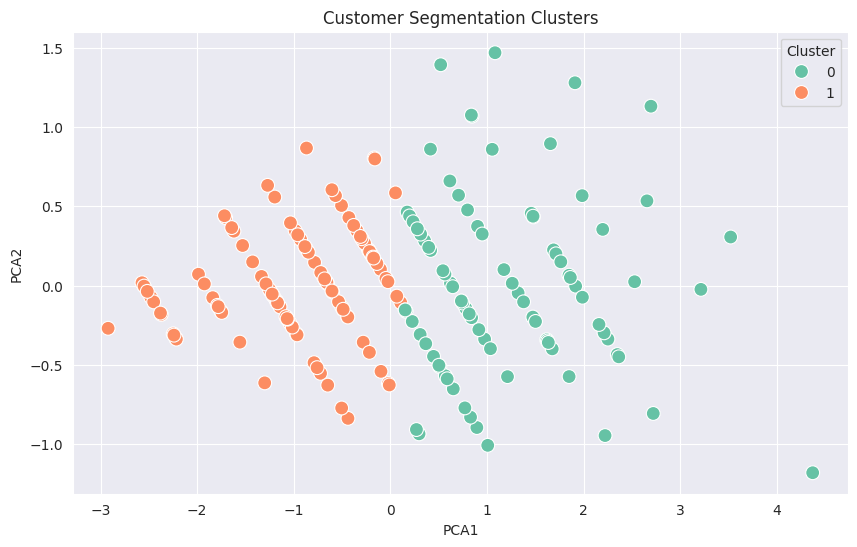

In [39]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features["PCA1"],
    y=customer_features["PCA2"],
    hue=customer_features["Cluster"],
    palette="Set2",
    s=100
)
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

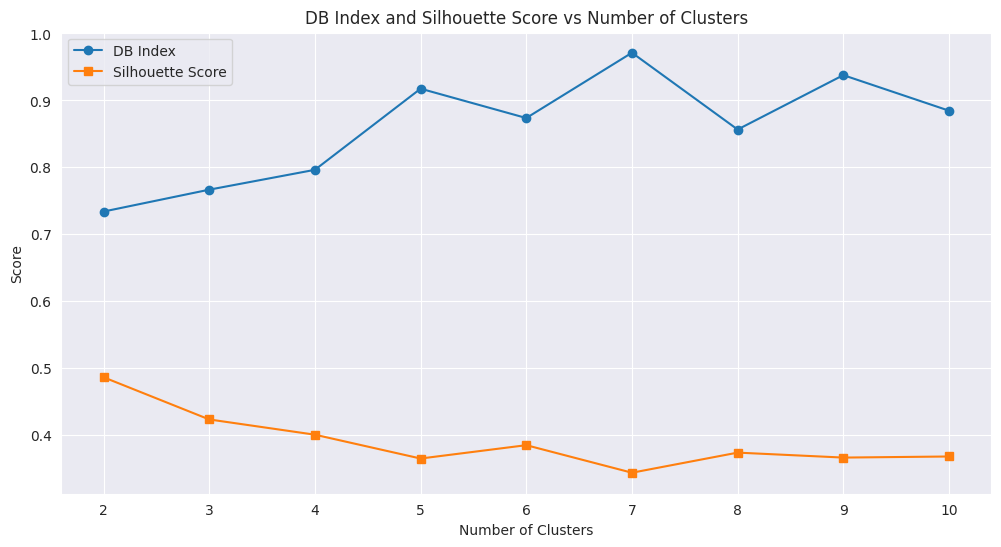

In [40]:
# Plot Davies-Bouldin Index and Silhouette Score for different cluster numbers
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, db_indices, marker="o", label="DB Index")
plt.plot(cluster_range, silhouette_scores, marker="s", label="Silhouette Score")
plt.xticks(cluster_range)
plt.title("DB Index and Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [41]:
# Print DB Index and clustering summary
print(f"Optimal number of clusters: {optimal_k}")
print(f"DB Index for optimal clustering: {min(db_indices):.2f}")
print(f"Silhouette Score for optimal clustering: {silhouette_optimal:.2f}")



Optimal number of clusters: 2
DB Index for optimal clustering: 0.73
Silhouette Score for optimal clustering: 0.49


In [42]:
# Save results to a CSV file
customer_features.to_csv("Customer_Clusters.csv", index=False)

## Additional visualizations

In [43]:
# Cluster Distribution Analysis
cluster_distribution = customer_features["Cluster"].value_counts()
print("\nDistribution of Customers Across Clusters:")
for cluster, count in cluster_distribution.items():
    print(f"Cluster {cluster}: {count} customers")


Distribution of Customers Across Clusters:
Cluster 1: 111 customers
Cluster 0: 89 customers


/tmp/ipykernel_16417/1979507370.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=customer_features, palette="Set2")


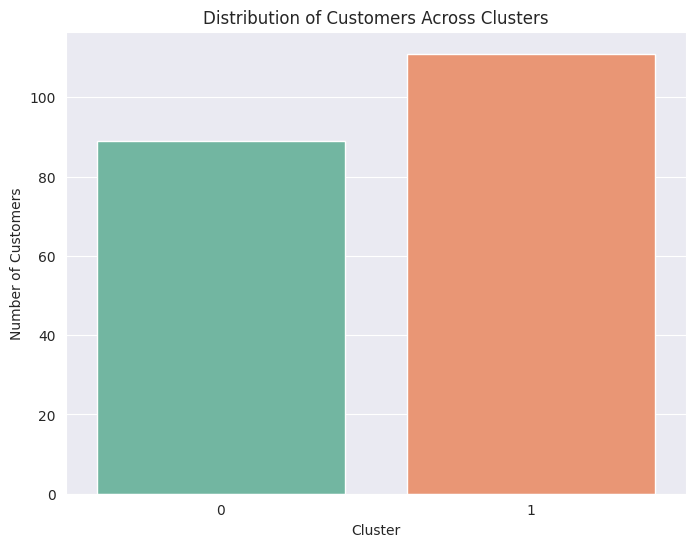

In [44]:
# Distribution of clusters
plt.figure(figsize=(8, 6))
sns.countplot(x="Cluster", data=customer_features, palette="Set2")
plt.title("Distribution of Customers Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

In [45]:
# Cluster-wise Average Spending and Transaction Frequency
print("\nCluster-wise Average Spending and Transaction Frequency:")
cluster_summary = customer_features.groupby("Cluster")[["TotalSpending", "TransactionFrequency"]].mean().reset_index()
for index, row in cluster_summary.iterrows():
    cluster = row["Cluster"]
    avg_spending = row["TotalSpending"]
    avg_frequency = row["TransactionFrequency"]
    print(f"Cluster {cluster}:")
    print(f"  - Average Spending: ${avg_spending:.2f}")
    print(f"  - Average Transaction Frequency: {avg_frequency:.2f} transactions")


Cluster-wise Average Spending and Transaction Frequency:
Cluster 0.0:
  - Average Spending: $5033.04
  - Average Transaction Frequency: 6.89 transactions
Cluster 1.0:
  - Average Spending: $2180.68
  - Average Transaction Frequency: 3.49 transactions


/tmp/ipykernel_16417/4076166795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Cluster", y="TotalSpending", data=cluster_summary, palette="Set2")


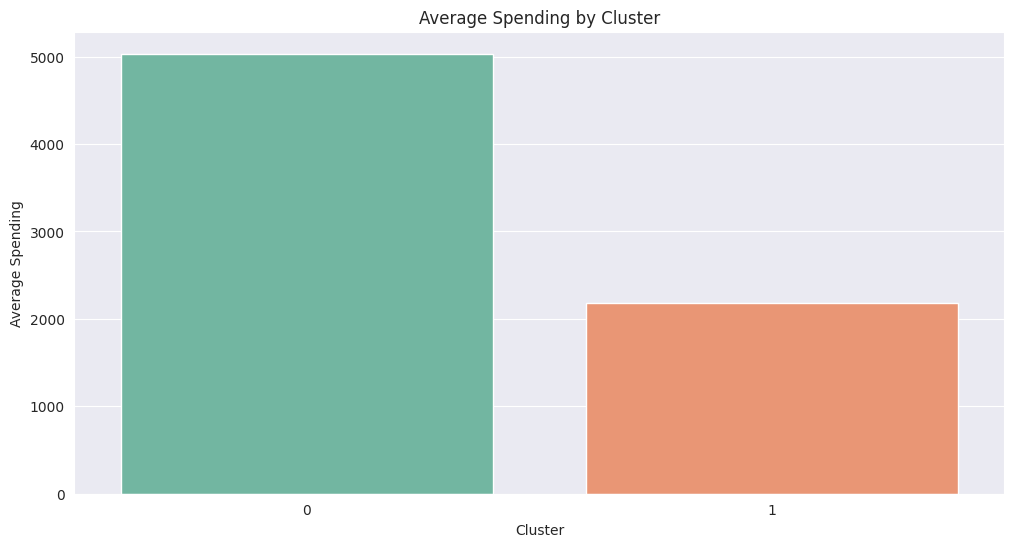

In [46]:
# Cluster-wise average spending and transaction frequency
plt.figure(figsize=(12, 6))
sns.barplot(x="Cluster", y="TotalSpending", data=cluster_summary, palette="Set2")
plt.title("Average Spending by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending")
plt.show()

/tmp/ipykernel_16417/1443302348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Cluster", y="TransactionFrequency", data=cluster_summary, palette="Set2")


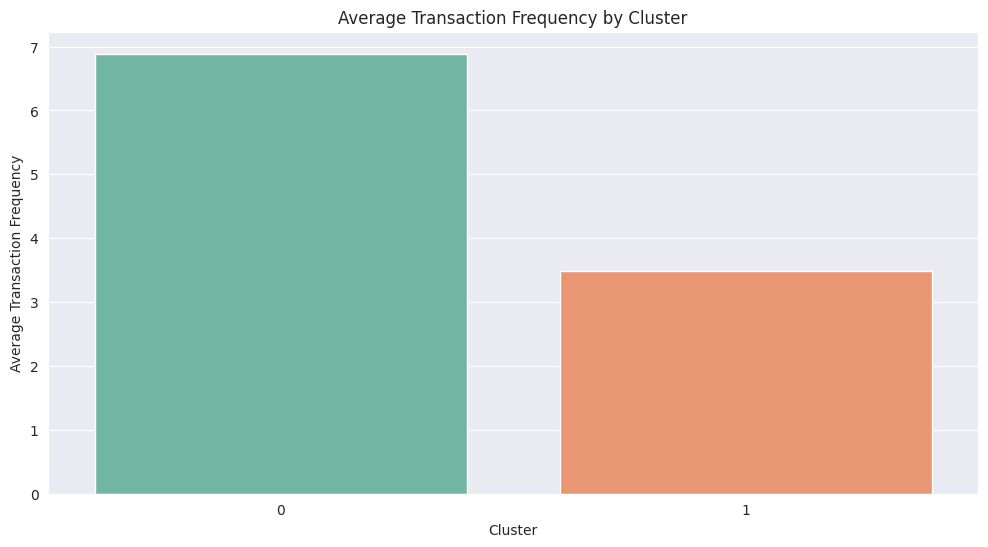

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Cluster", y="TransactionFrequency", data=cluster_summary, palette="Set2")
plt.title("Average Transaction Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Transaction Frequency")
plt.show()
